##### Importacao de bibliotecas e banco de dados

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from pandas.core.series import Series
from pandas.core.frame import DataFrame
import plotly.express as px

In [2]:
base_path = Path("database")
base_airbnb = pd.DataFrame()
for file in base_path.iterdir():
    if file.name.endswith(".csv"):
        month_df = pd.read_csv(base_path / file.name)
        month_df['last_scraped'] = pd.to_datetime(month_df['last_scraped'])
        month_df['year'] = month_df['last_scraped'].dt.year
        month_df['month'] = month_df['last_scraped'].dt.month
        base_airbnb = pd.concat([base_airbnb, month_df], ignore_index=True)


/tmp/ipykernel_27670/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_27670/3276474334.py:5: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_27670/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_27670/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_27670/3276474334.py:5: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  month_df = pd.read_csv(base_path / file.name)
/tmp/ipykernel_27670/3276474334.py:5: Dty

##### Limpeza do dataset

Como tempo muitas colunas no nosso dataset, o modelo fica mais lento.

Uma análise será feita para retirar as colunas que não serão necessárias para o nosso modelo de previsao.

colunas que serão excluídas:

- IDs, links e informações nao relevantes ao modelo.
- criada colunas separadas para ano e mes de extracao (mais util para a análise), excluindo a coluna com a data completa
- Colunas preenchidas com texto livre (nao será utilizado nenhuma análise de palavras, ou LLM, focando-se um modelo mais simples)
- colunas com todos (ou proximo a isso) são iguais
- precos que nao sejam diarios
- informacoes fiscais exigidas (análise busca verificar características do imovel)

In [3]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [4]:
columns = [
    "host_response_time",
    "host_response_rate",
    "host_is_superhost",
    "host_listings_count",
    "latitude",
    "longitude",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "amenities",
    "price",
    "security_deposit",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "instant_bookable",
    "is_business_travel_ready",
    "cancellation_policy",
    "year",
    "month",
]
base_airbnb = base_airbnb.loc[:, columns]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,year,month
0,within an hour,100%,t,2.0,-22.965920,-43.178960,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,11
1,within a day,91%,f,3.0,-22.977120,-43.190450,Apartment,Entire home/apt,2,1.0,...,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,11
2,within an hour,100%,t,1.0,-22.983020,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,11
3,within an hour,100%,t,1.0,-22.988160,-43.193590,Apartment,Entire home/apt,3,1.5,...,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,11
4,within an hour,100%,t,1.0,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,100%,t,22.0,-22.982284,-43.190167,Apartment,Entire home/apt,4,1.5,...,NaN,NaN,NaN,NaN,NaN,t,f,strict_14_with_grace_period,2018,7
902206,within a day,80%,f,2.0,-23.019163,-43.488247,Serviced apartment,Private room,2,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,moderate,2018,7
902207,within a day,60%,f,19.0,-22.964826,-43.177641,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2018,7
902208,NaN,NaN,f,1.0,-22.890793,-43.440360,House,Entire home/apt,7,2.0,...,NaN,NaN,NaN,NaN,NaN,t,f,flexible,2018,7


#### Tratando dados Faltantes

Visualizando os dados, percebemos que existem uma grande disparidade em dados faltantes.
- as colunas comm mais de 300 mil valores nulos foram excluidas da análise
- Para as demais colunas, como temos mais de 900 mil linhas, vamos simplesmente exlcuir com os dados nulos

In [5]:
print(base_airbnb.isnull().sum())
for column in base_airbnb:
    if base_airbnb[column].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(column, axis=1)
print(base_airbnb.shape)

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [6]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
year                        0
month                       0
dtype: int64
(897709, 23)


In [7]:
print(base_airbnb.dtypes)
print("-"*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int32
month                         int32
dtype: object
------------------------------------------------------------
host_is_superhost                                                           t
host_listings_count

Como preço e extra_people estão sendo reconhecidos como objeto ao ines de float, tempo de mudar o tipo de variável da coluna

In [8]:
# alterar price, extra_people
base_airbnb["price"] = base_airbnb["price"].str.replace("$", "").str.replace(",", "")
base_airbnb["price"] = base_airbnb["price"].astype(np.float32, copy=False)
base_airbnb["extra_people"] = base_airbnb["extra_people"].str.replace("$", "").str.replace(",", "")
base_airbnb["extra_people"] = base_airbnb["extra_people"].astype(np.float32, copy=False)
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
year                          int32
month                         int32
dtype: object


#### Análise Exploratória e Tratamento de Outliers

Analisando caracteristica por caracteristica, iremos:

- Ver a correlação entre as features e decidir se manteremos todas as features que temos
- Exluir outliers (usaremos como regra: valores abaixo de Q1 - 1,5 x Amplitude e valores acima de Q3 + 1,5 x Amplitude) onde Amplitude = Q3 - Q1
- Confirmar se todas as features que temos realmente fazem sentido para o nosso modelo ou se alguma delas nao irá nos ajudar ou se devemos excluí-la

<Axes: >

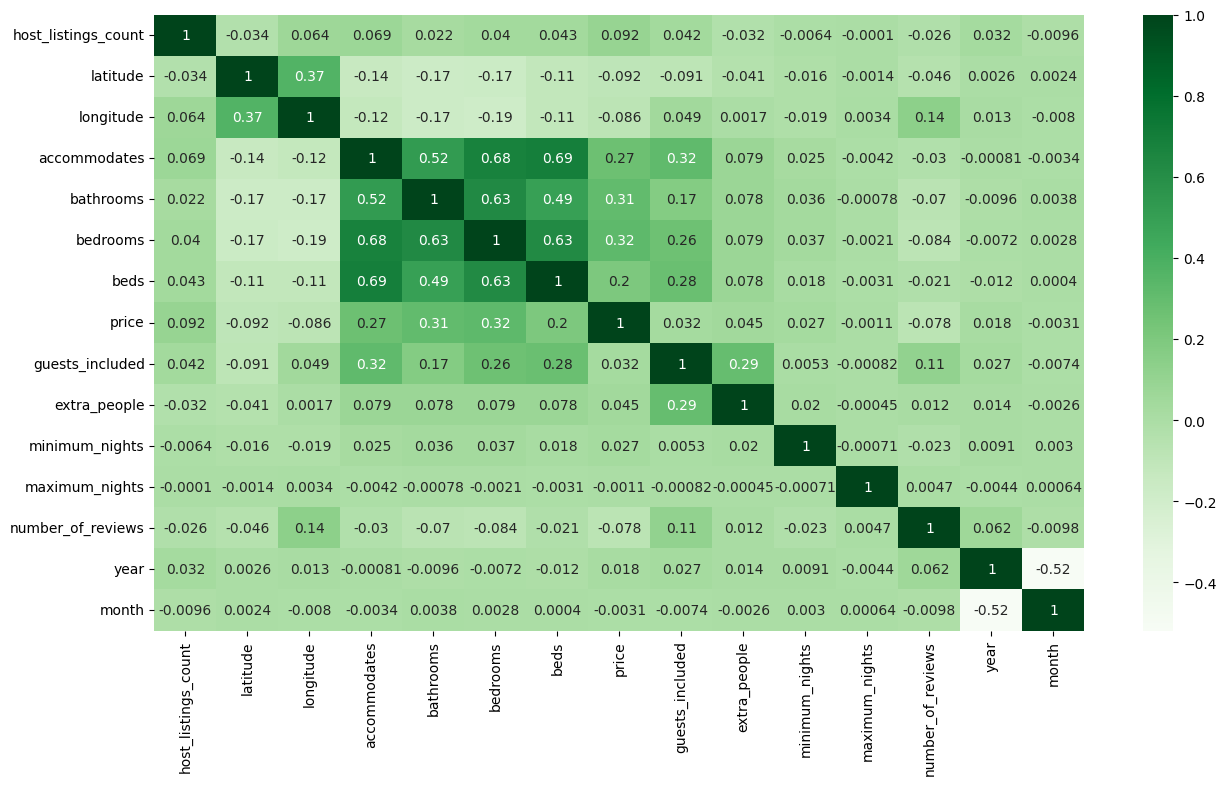

In [9]:
# analise de correlacao
plt.figure(figsize=(15,8))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

 #### Definição de funcoes para determinar outliers

 Utilizando o conceito de Quartil (que é qualquer um dos três valores que divide o conjunto ordenado de dados em quatro partes iguais) para definir os outliers.


In [10]:
def calculate_limits(column: Series):
    first_quantile = column.quantile(0.25)  # definindo o primeiro quartil
    third_quantile = column.quantile(0.75)  # definindo o terceiro quartil
    amplitude = third_quantile - first_quantile
    inferior_limit = first_quantile - (1.5 * amplitude)
    superior_limit = third_quantile + (1.5 * amplitude)
    return inferior_limit, superior_limit


def remove_outliers(df: DataFrame, column_name: str):
    old_lines_number = df.shape[0]
    column: Series = df[column_name]
    inferior_limit, superior_limit = calculate_limits(column)
    filtered_df = df.loc[(column >= inferior_limit) & (column <= superior_limit), :]
    removed_line_number = old_lines_number - filtered_df.shape[0]
    return filtered_df, removed_line_number

In [11]:
def boxplot_builder(column: Series):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2: Axes
    ax2.set_xlim(calculate_limits(column))
    sns.boxplot(x=column, ax=ax2)


# TODO: melhorar grafico de histograma
def histogram_builder(column):
    plt.figure(figsize=(15, 5))
    # sns.distplot(column, hist=True)
    sns.histplot(column, kde=True, stat="density")
    # sns.displot(column)


def barplot_builder(column: Series, show_all: bool = False):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    if show_all is False:
        ax.set_xlim(calculate_limits(column))


def countplot_builder(data: DataFrame, column_name: str):
    plt.figure(figsize=(15, 5))
    plot: Axes = sns.countplot(data=data, x=column_name)
    plot.tick_params(axis="x", rotation=90)


Vamos primeiro analisar as colunas com quantidades continuas, ou seja, com variação decimal, que seriam as colunas de price e extra_people

### Price

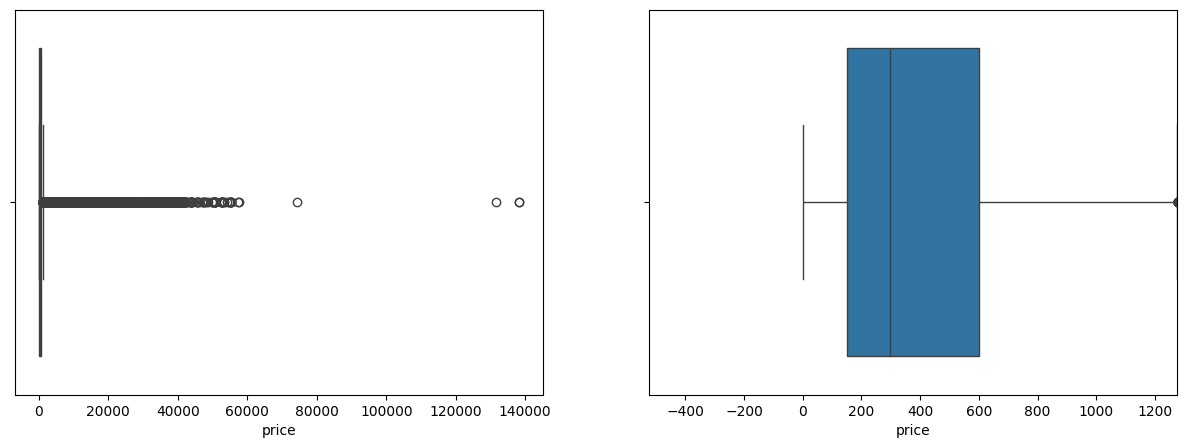

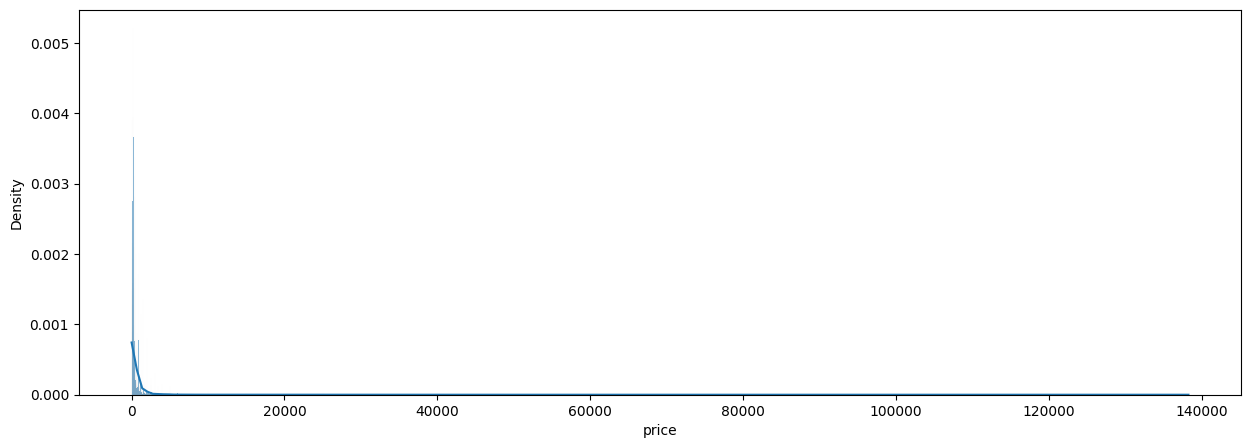

In [12]:
boxplot_builder(base_airbnb["price"])
histogram_builder(base_airbnb["price"])

Como estamos construindo um modelo para imóveis comum, acredito que os valores acima do limite superior serão apenas de apartamentos de alto padrao, que nao se encaixam no nosso objetivo principal. Por isso, iremos excluir os outliers

In [13]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "price")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  87282


Um comentário feito pelo autor do dataset que achei interessante salientar:
em precos cheios existem picos, uma ves que as proprias pessoas definem os precos, e intuitivamente é costumeiro determinar precos cheios e é poossivel analisar isso no histograma agora filtrado.

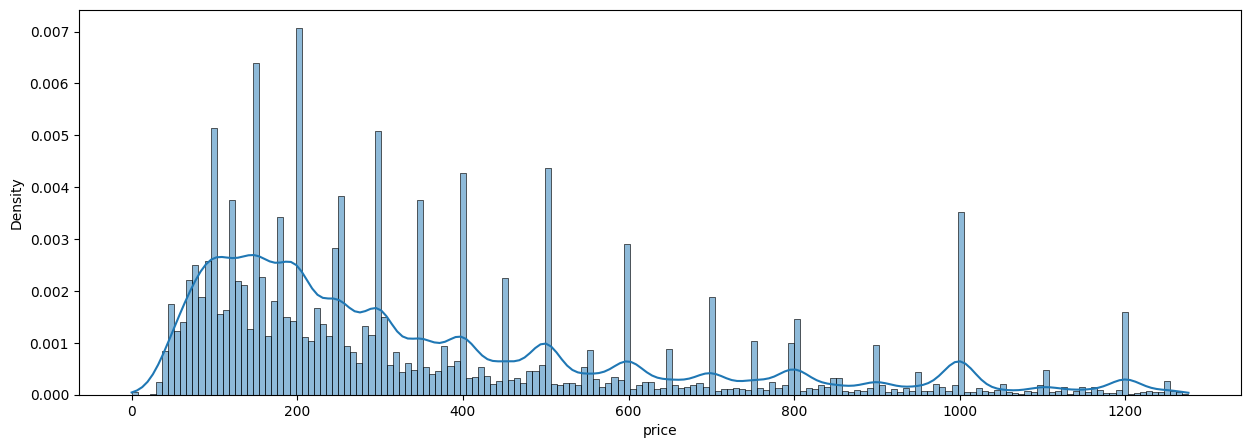

In [14]:
histogram_builder(base_airbnb["price"])

#### extra_people

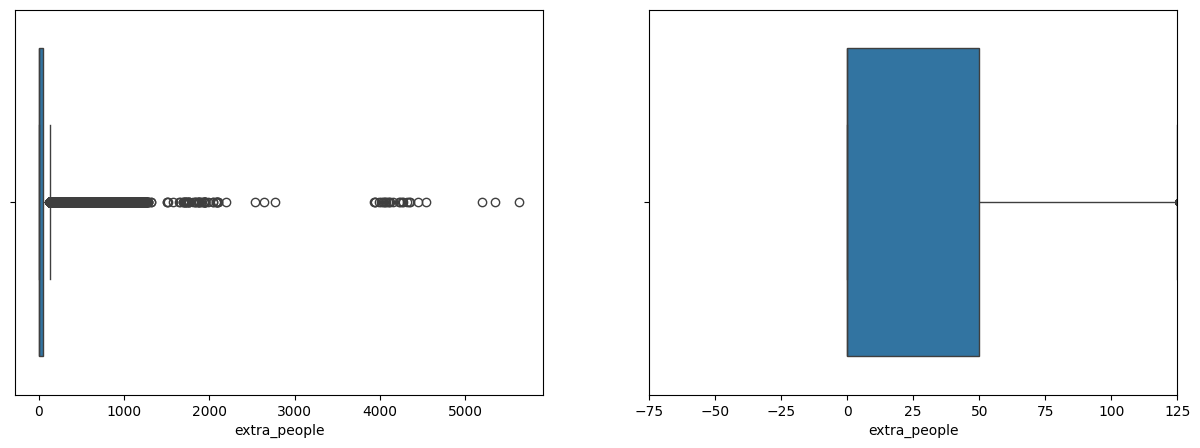

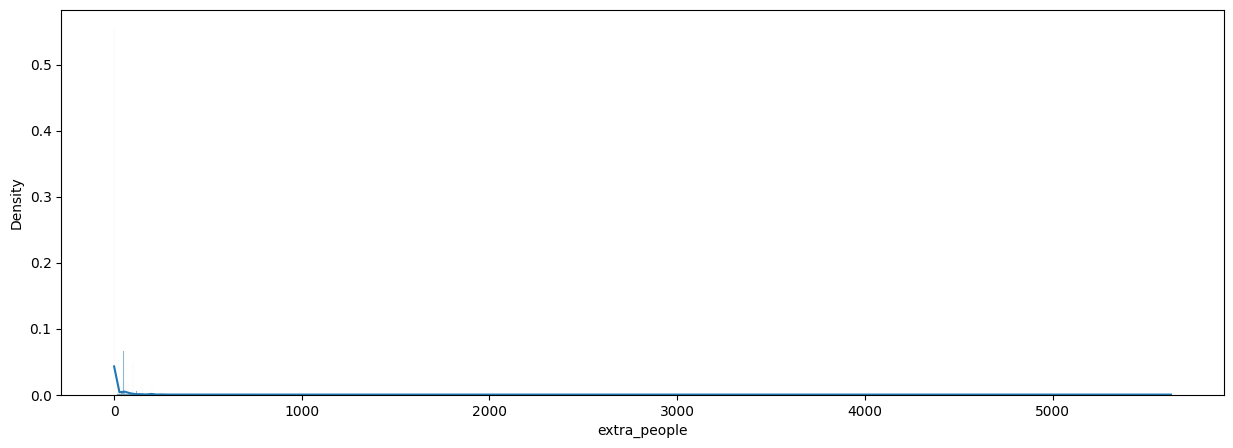

In [15]:
boxplot_builder(base_airbnb["extra_people"])
histogram_builder(base_airbnb["extra_people"])

In [16]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "extra_people")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  59194


depois partiremos para analise de outiliers das colunas com valores discretos, com acrescimos inteiros, que seriam: accomodates, bedrooms, guests_included, etc

#### host_listings_count

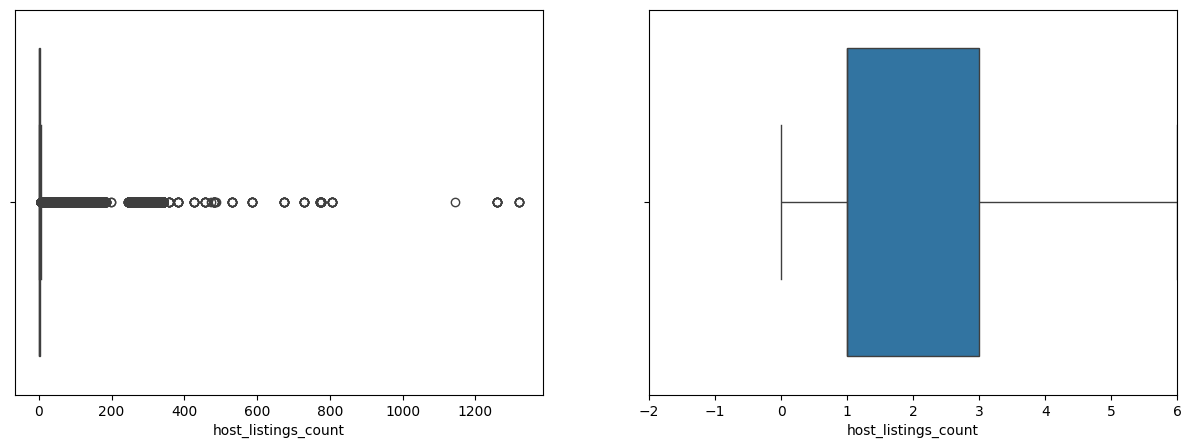

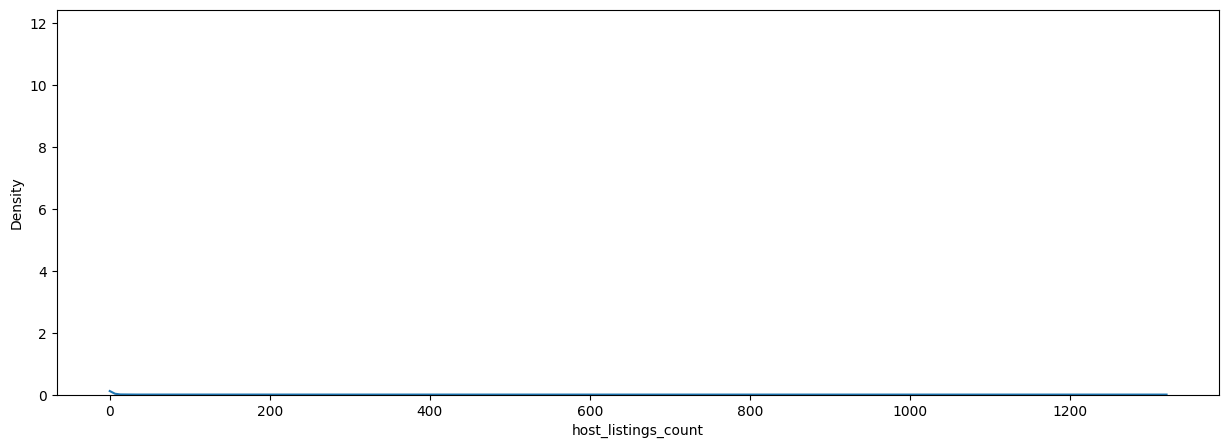

In [17]:
boxplot_builder(base_airbnb["host_listings_count"])
histogram_builder(base_airbnb["host_listings_count"])

visualizacao das features discretas nao ficou boa utilizando o grafico de histograma, sera entao utilizado o grafico de barras para avisualizacao, limitando o eixo x para ser exibir apenas dentro dos limites

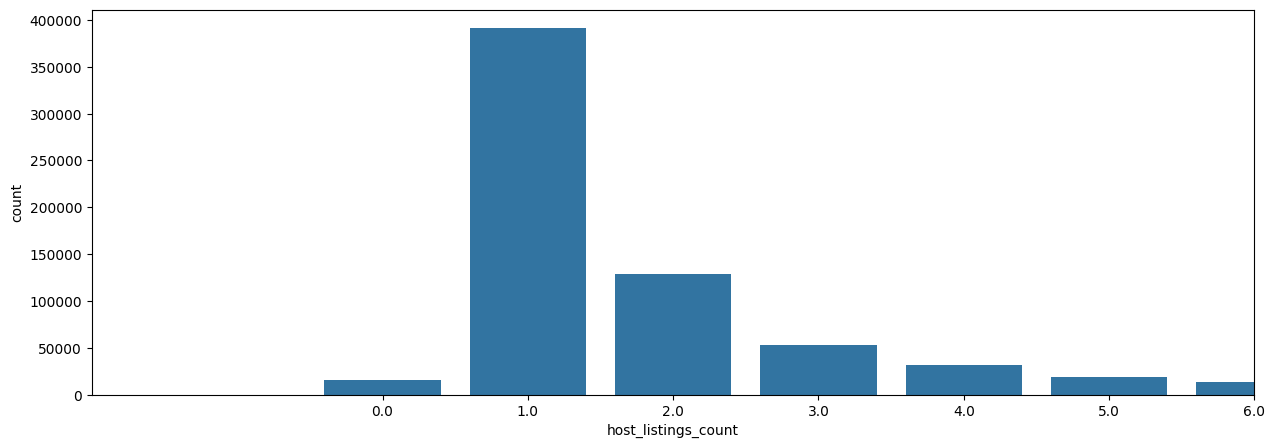

In [18]:
barplot_builder(base_airbnb["host_listings_count"])

podemos excluir os outilers porque para os objetivos do nosso projeto, hosts com mais de 6 imoveis no airbnb nao são o publico alvo do nosso objetivo (imagina-se que sejam imobiliários ou profissionais que gerenciam imoveis no airbnb)

In [19]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "host_listings_count")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  97723


#### accommodates

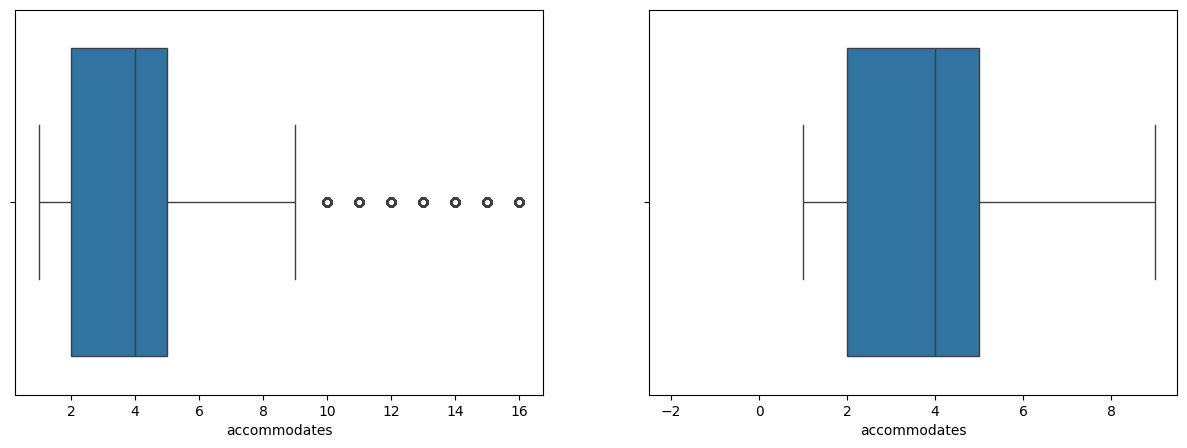

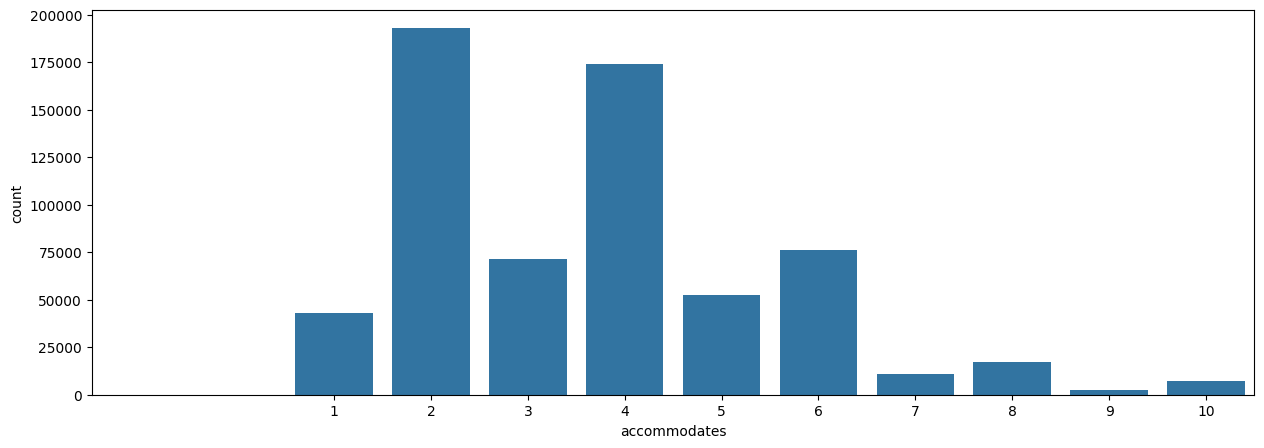

In [20]:
boxplot_builder(base_airbnb["accommodates"])
barplot_builder(base_airbnb["accommodates"])

In [21]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "accommodates")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  13146


#### bathrooms

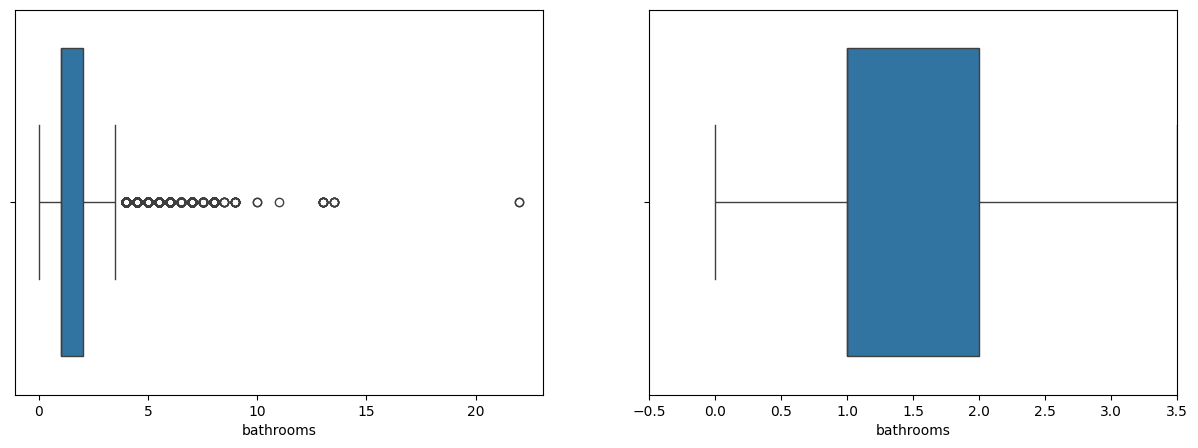

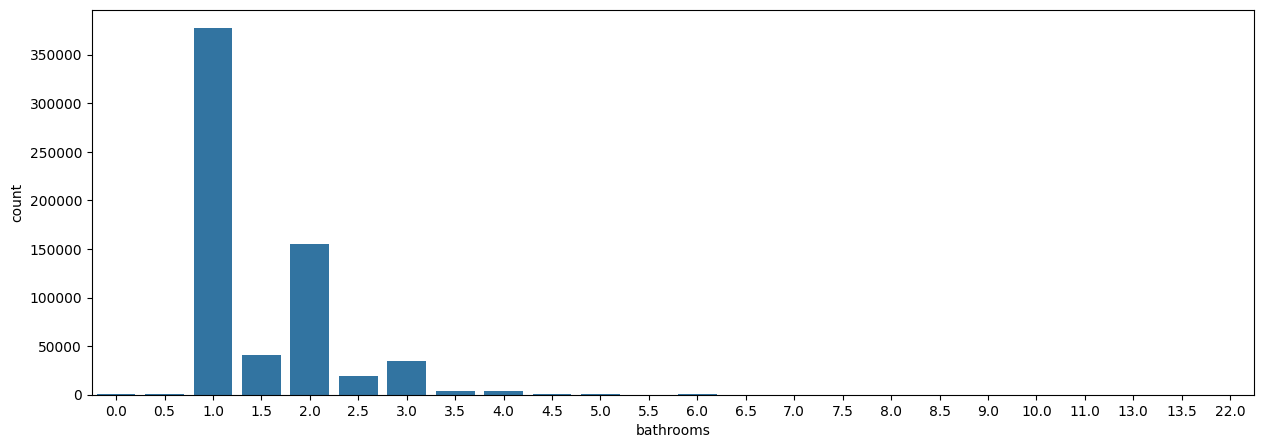

In [22]:
boxplot_builder(base_airbnb["bathrooms"])
barplot_builder(base_airbnb["bathrooms"], show_all=True)

In [23]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "bathrooms")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  6894


#### bedrooms

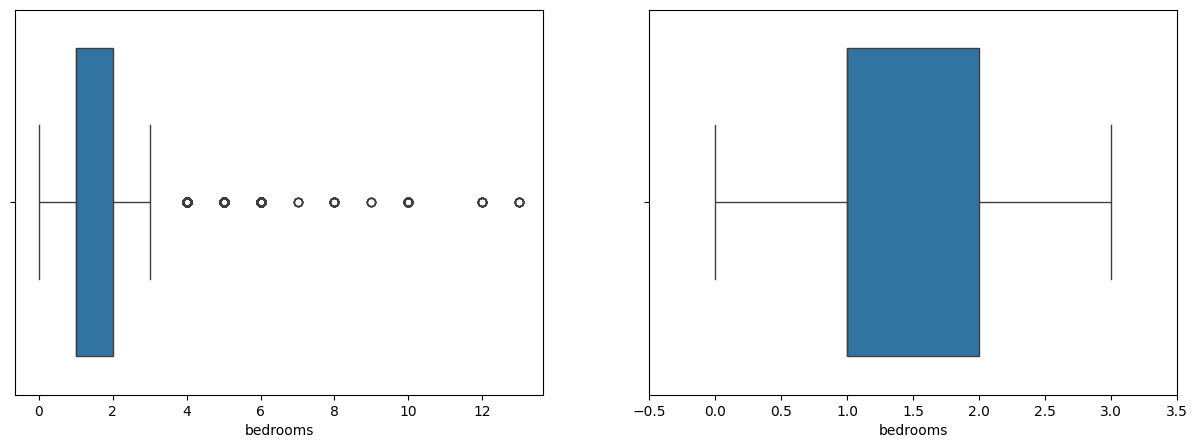

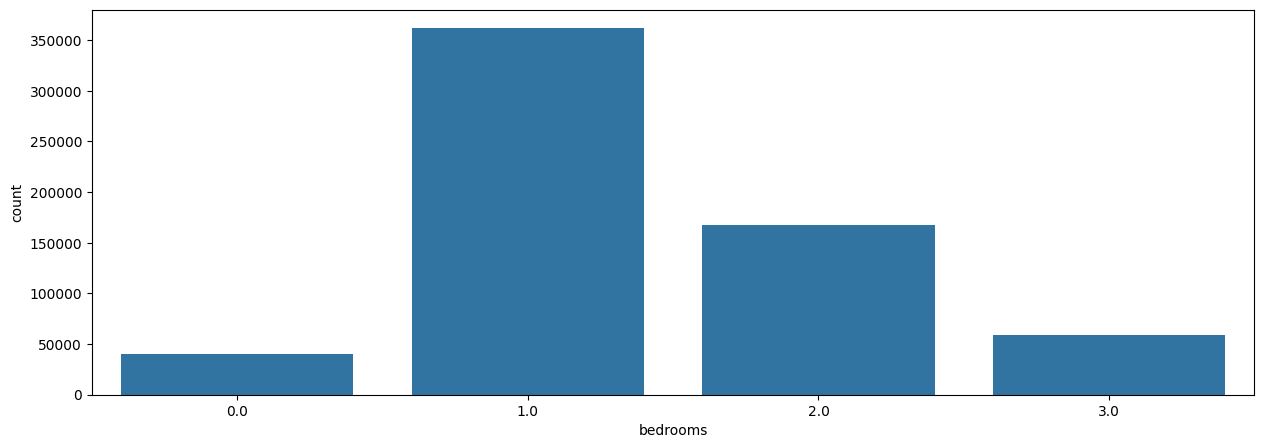

In [24]:
boxplot_builder(base_airbnb["bedrooms"])
barplot_builder(base_airbnb["bedrooms"])

In [25]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "bedrooms")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  5482


#### beds

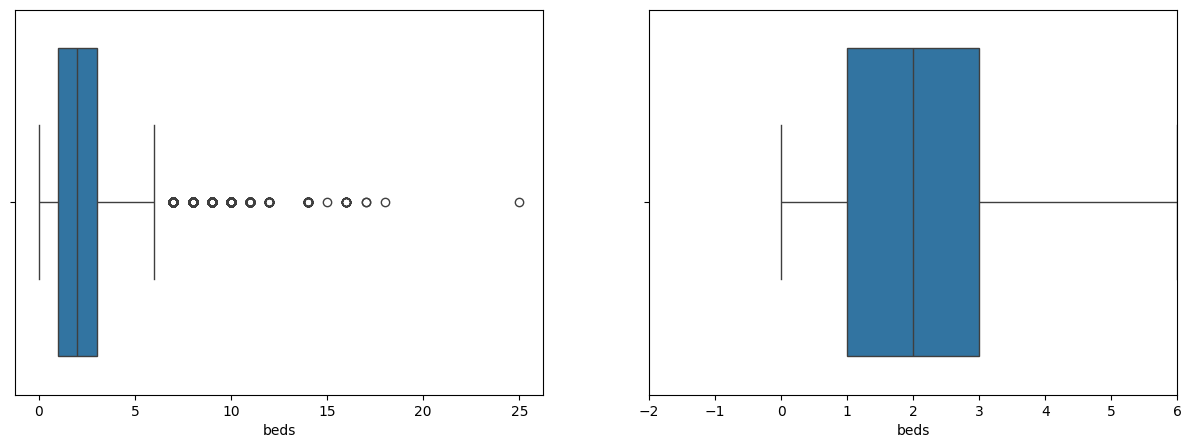

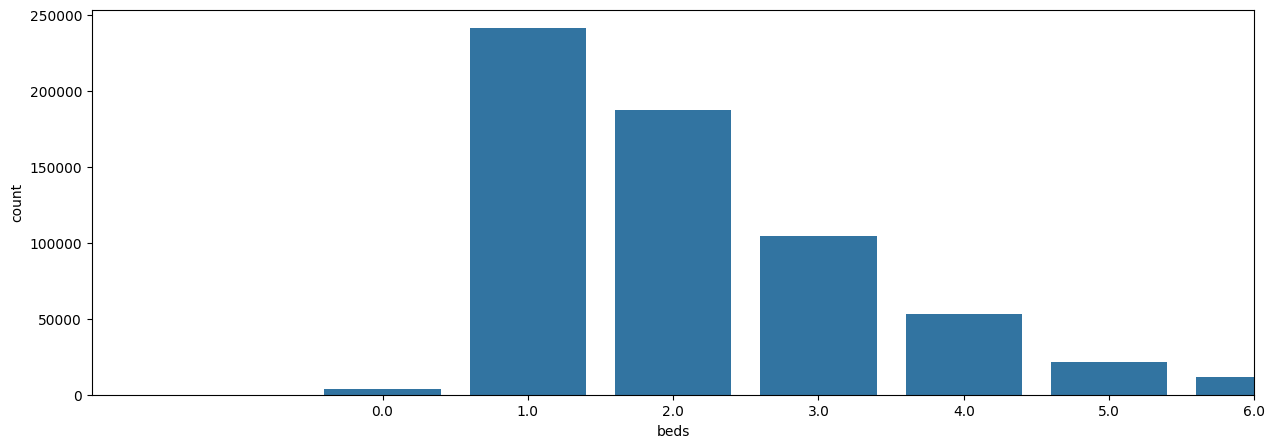

In [26]:
boxplot_builder(base_airbnb["beds"])
barplot_builder(base_airbnb["beds"])

In [27]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "beds")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  5622


#### ghests_included

/tmp/ipykernel_27670/915518257.py:6: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(calculate_limits(column))
/tmp/ipykernel_27670/915518257.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(calculate_limits(column))


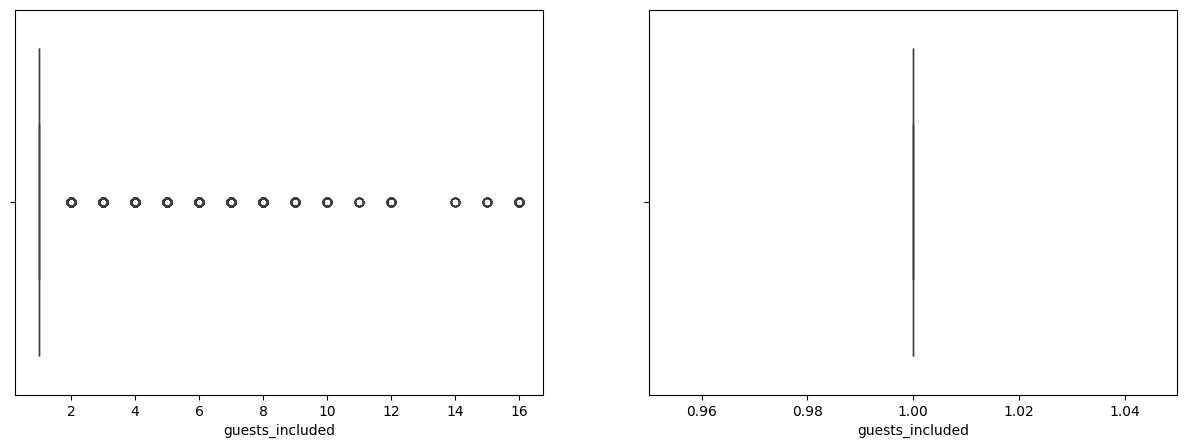

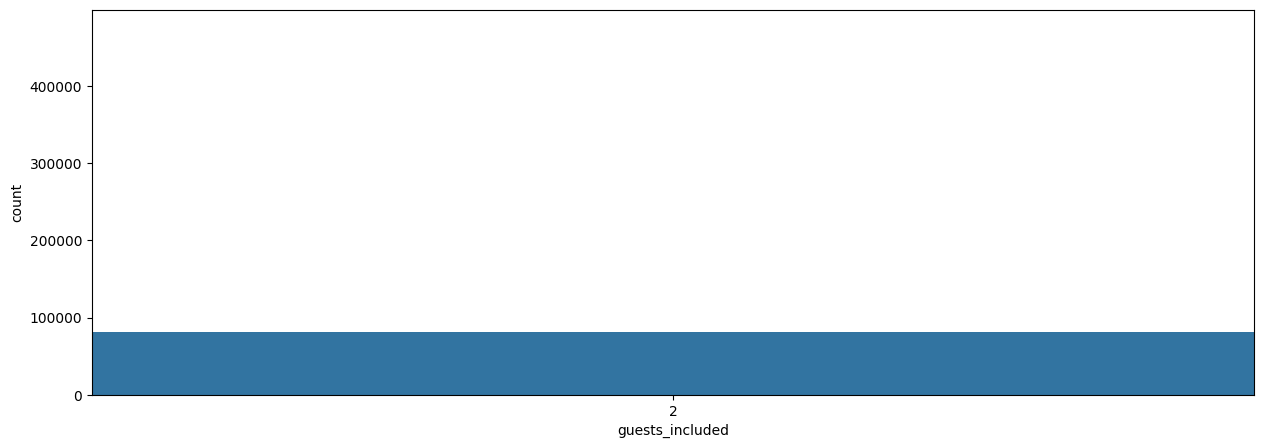

In [28]:
boxplot_builder(base_airbnb["guests_included"])
barplot_builder(base_airbnb["guests_included"])

In [29]:
print(calculate_limits(base_airbnb["guests_included"]))

(np.float64(1.0), np.float64(1.0))


analisando os limites, percebemos que ambos os limites dao como 1
muitos dados seriam perdidos se usassemos os limites da forma que estamos usando, para excluir os outliers fora deles
a causa disso pode ser erros de preenchimento desse dado em específico dos locadores no momento de definir o imovel (de onde os dados são extraidos), possivelmente usando um valor padrao já apontado.
removendo os outliers de guest included podemos ter problemas por remover muitos dados que nesse caso seriam interessantes para a diversidade do nosso modelo
entao nao iremos remover os outilers e iremos remover essa feature da nossa analise

In [30]:
base_airbnb = base_airbnb.drop("guests_included", axis=1)
base_airbnb.shape

(622366, 22)

#### minimum_nights

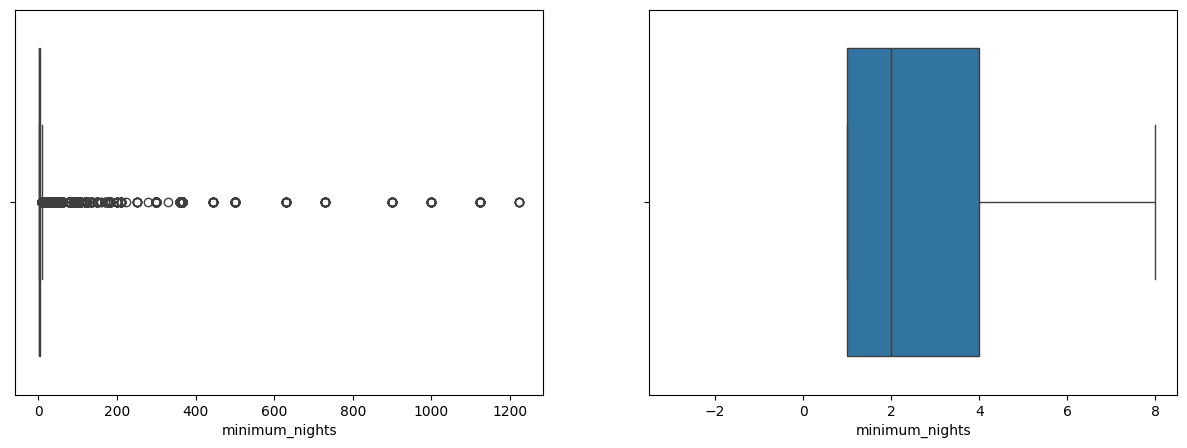

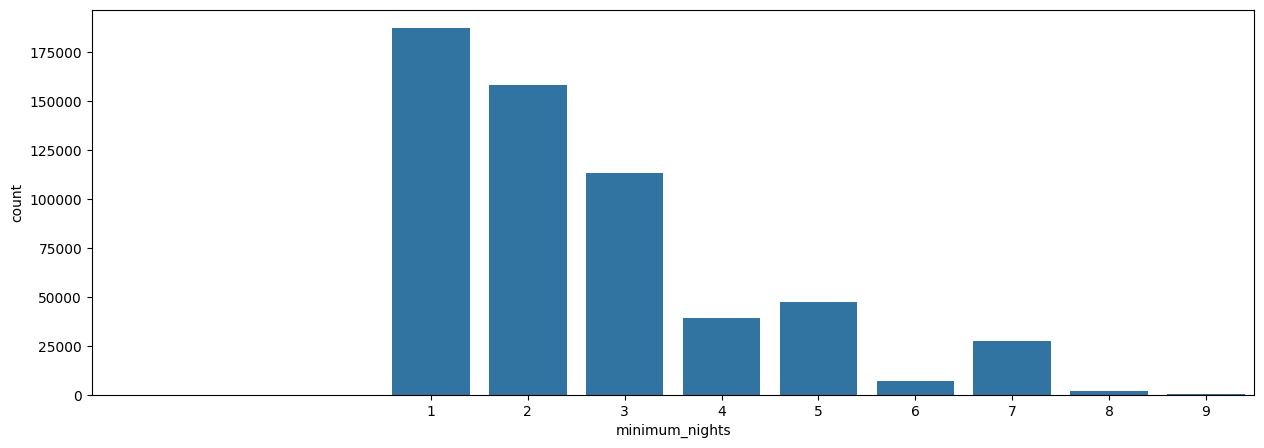

In [31]:
boxplot_builder(base_airbnb["minimum_nights"])
barplot_builder(base_airbnb["minimum_nights"])

In [32]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "minimum_nights")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  40383


#### maximum_nights

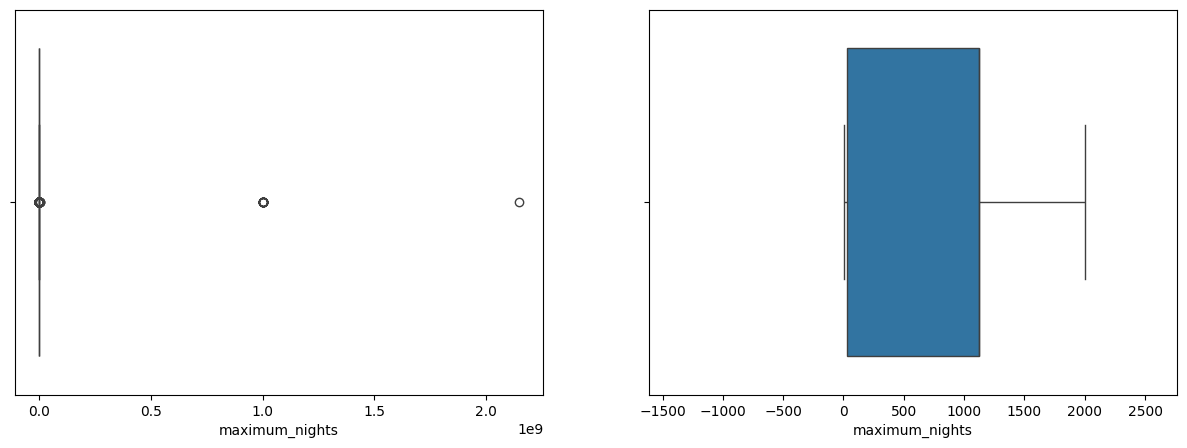

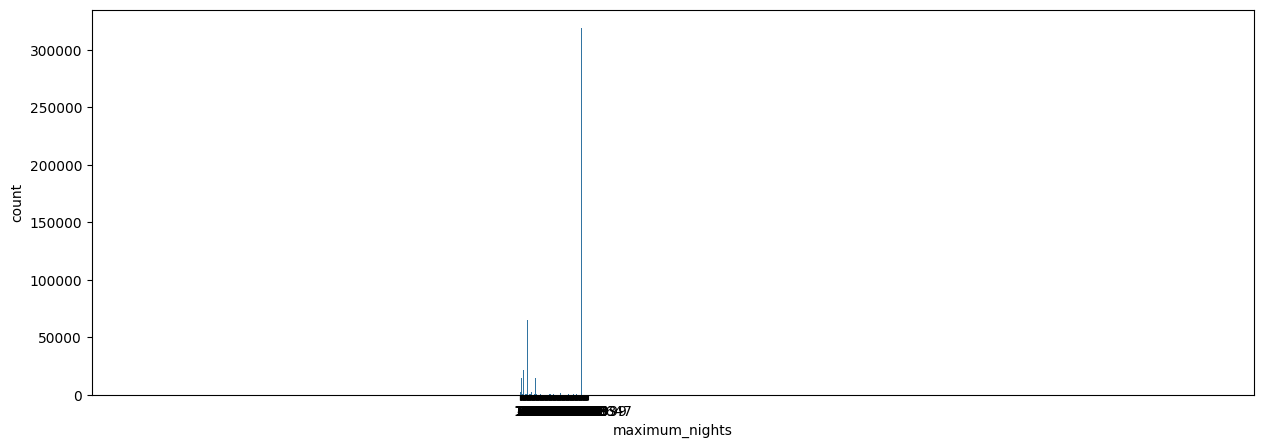

In [33]:
boxplot_builder(base_airbnb["maximum_nights"])
barplot_builder(base_airbnb["maximum_nights"])

temos muitos valores zerados e outra grande porcao de valores grandes
a mesma suposicao utilizada para guests included será utilizada aqui, de que no preenchimento e cadastro dos imoveis, a parte dos imoveis que estamos interessados e filtrando ate aqui nao deve cadastrar corretamente e um valor padrao (nesse caso 0 aparentemente) esta cadastrado
nao parece ser uma metrica boa para nossa analise, deve apenas prejudicar nosso modelo se tentarmos adaptar ou retirar todos os valores atraves da mesma logica

In [34]:
base_airbnb = base_airbnb.drop("maximum_nights", axis=1)
base_airbnb.shape

(581983, 21)

#### number_of_reviews  

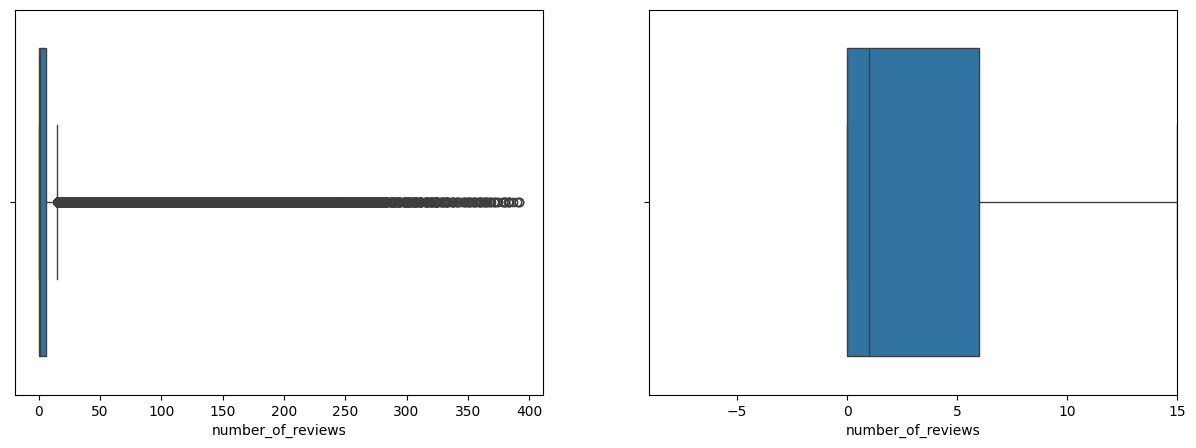

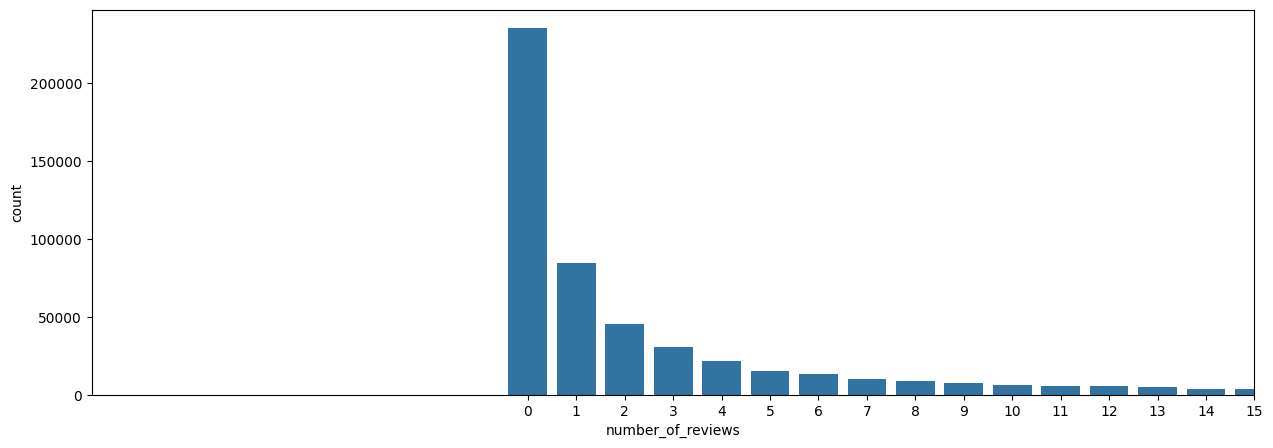

In [35]:
boxplot_builder(base_airbnb["number_of_reviews"])
barplot_builder(base_airbnb["number_of_reviews"])

retirar os imoveis com numeros de reviews acima do nossos limites nao faz sentido, ja que pode ser apenas um imovel com mais tempo de aplicativo, talvez tendo apenas coisas positivas, como um preco muito bom, o que seria otimo para o nosso modelo
tirando esses dados, tiraria os melhores hosts do nosso modelo

iremos prefirir tirar essa feature porque queremos construit um modelo que nao tenha nenhum review, ja que queremos criar o modelo para qualquer pessoa que queira disponibilizar um umovel, independente do numero de reviews previos
tentaremos criar um modelo que nao dependa ou nao tenha interferencia do numero de reviews

In [36]:
base_airbnb = base_airbnb.drop("number_of_reviews", axis=1)
base_airbnb.shape

(581983, 20)

agora vamos entrar na analise das colunas que sao texto, e iremos tratar textos como categorias
vamos pensar em como vamos tratar essas catgegorias para nao deixar nosso modelo muito pulverizado

iremos agrupar para diminuir os numeros de categorias, senao teriamos uma quantidade tao grande de categorias que poderia tornar um modelo muito complexo quando ele poderia ficar mais simples/rapido chegando em uma resposta tao boa quanto

#### property_type

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

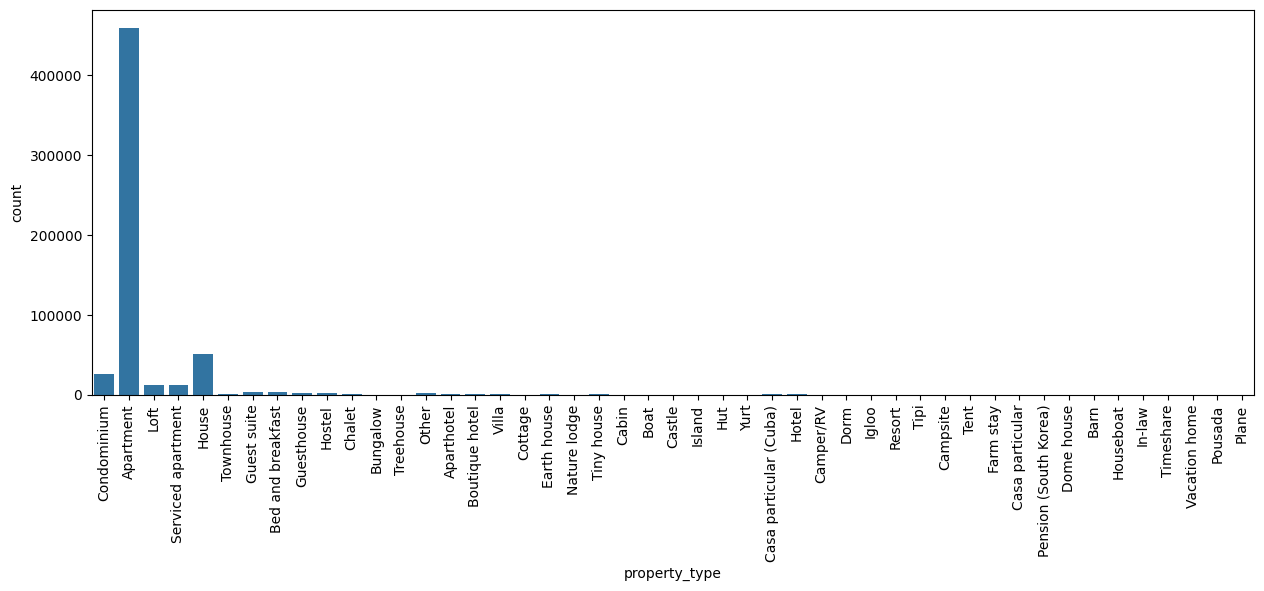

In [37]:
print(base_airbnb["property_type"].value_counts())
countplot_builder(data=base_airbnb, column_name="property_type")


tudo o que tiver valores pequenos serão colocados em uma unica categorias chamada "others"
analisando todos os values, todos abaixo da já utilizada categoria "Others" serão agrupadas nessa mesma categorias
claro que varias das caracteristicas enquadradas aqui serão muito diferentes, e aqui realmente é uma parte critica da ontagem do nosso modelo, e aqui deve-se ter um checkpoint para revisitar no momento de analisar os resultados do modelo caso nao sejam satisfatórios, ou deseja-se fazer testes para alterar a abordagem quanto ao tratamento das colunas de texto/categorias

In [38]:
property_types_series: Series = base_airbnb["property_type"].value_counts()
group_other_types = []

for prop_type in property_types_series.index:
    if property_types_series[prop_type] < 2000:
        group_other_types.append(prop_type)
print(group_other_types)  # tipos que serao agrupados como "outros"

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Houseboat', 'Pousada', 'Timeshare', 'Casa particular', 'Plane']


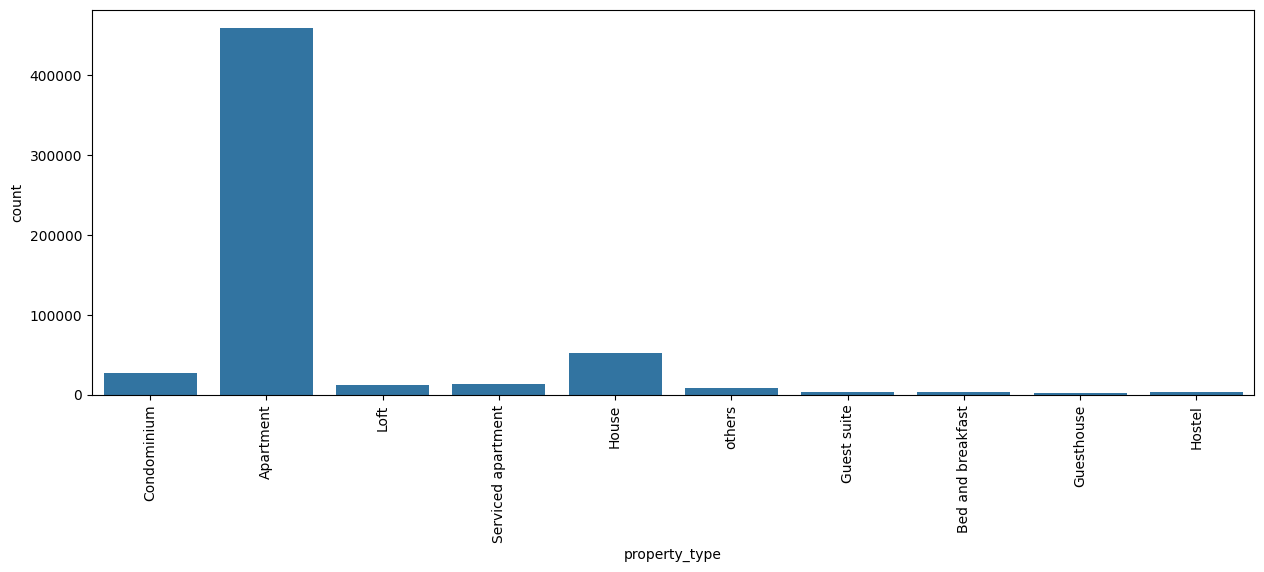

In [39]:
for prop_type in group_other_types:
    base_airbnb.loc[base_airbnb["property_type"] == prop_type, "property_type"] = "others"
countplot_builder(column_name="property_type", data=base_airbnb)

#### room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


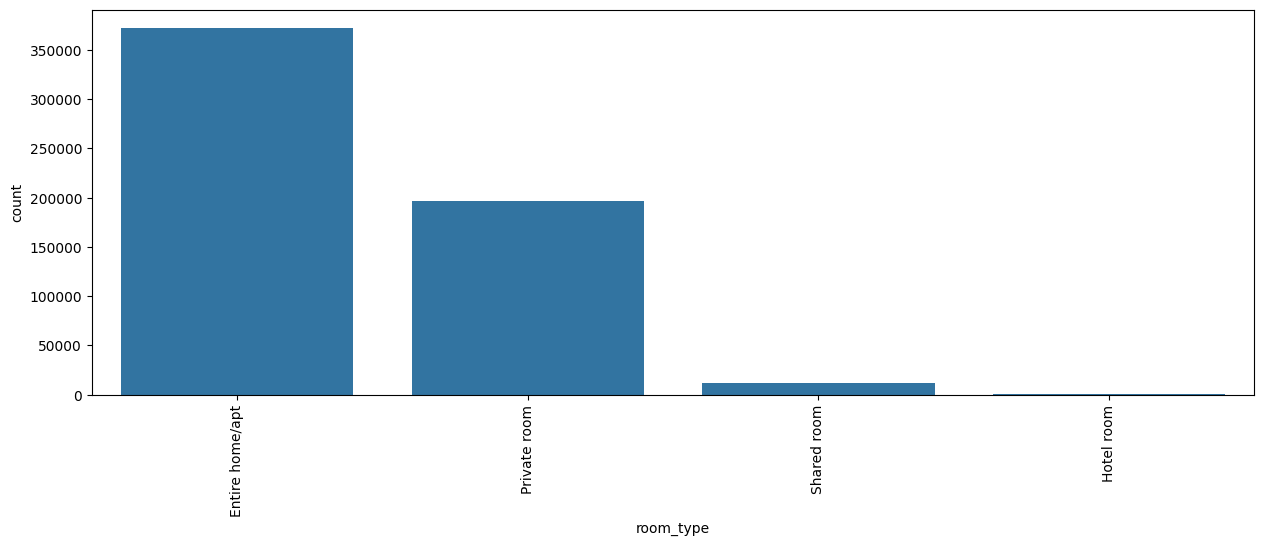

In [40]:
print(base_airbnb["room_type"].value_counts())
countplot_builder(column_name="room_type", data=base_airbnb)

tratamento nao precisará ser feito, temos ooucas categorias e nao criará problemas para o modelo de aumentar seu tempo de processamento

#### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


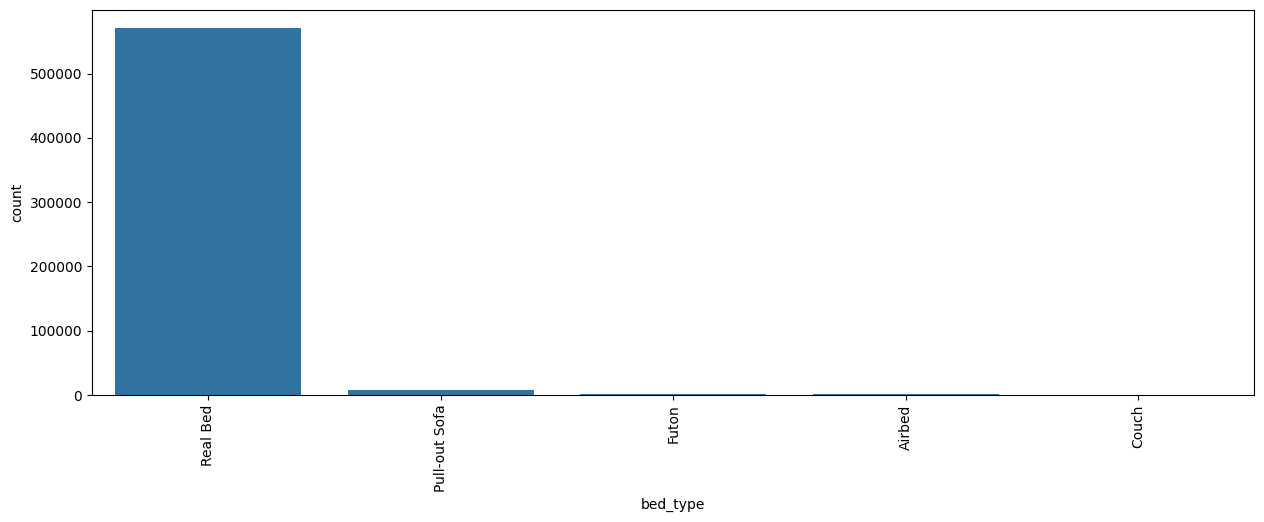

In [41]:
print(base_airbnb["bed_type"].value_counts())
countplot_builder(column_name="bed_type", data=base_airbnb)

#### cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


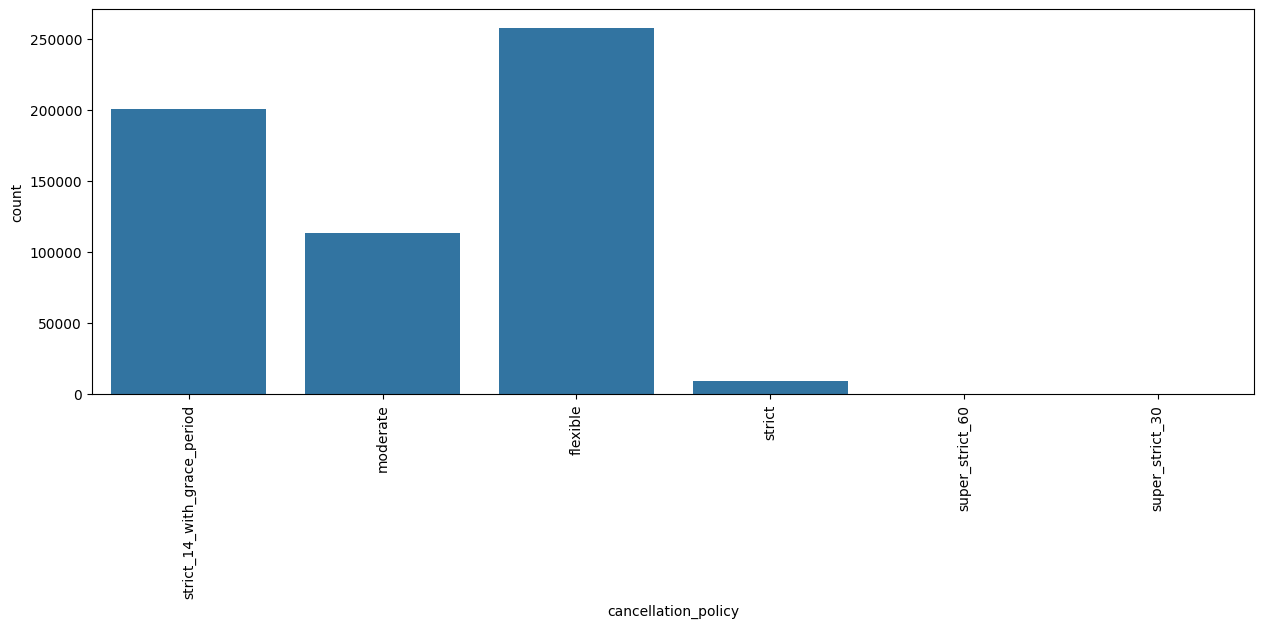

In [42]:
print(base_airbnb["cancellation_policy"].value_counts())
countplot_builder(column_name="cancellation_policy", data=base_airbnb)

iremos agrupar as categorias strict em uma só, nao entrando em detalhes maiores sobre o cancelamento, apenas se é estrita ou nao, para simplificar o modelo

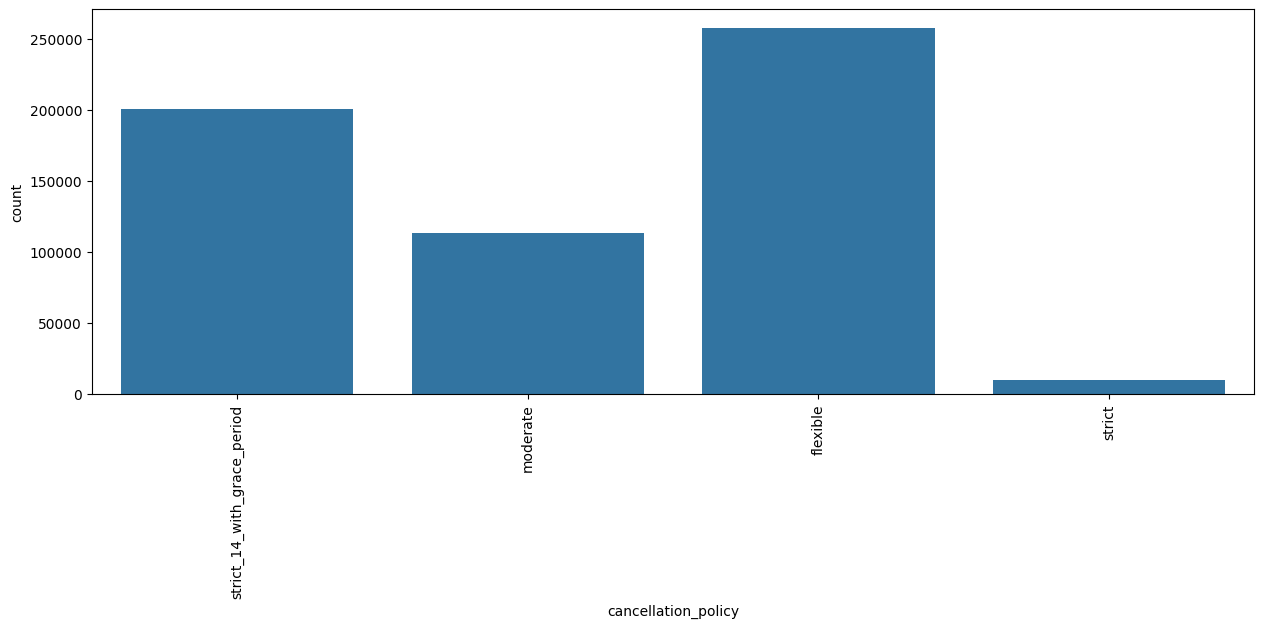

In [43]:
property_types_series: Series = base_airbnb["cancellation_policy"].value_counts()
group_other_types = []

for prop_type in property_types_series.index:
    if property_types_series[prop_type] < 10000:
        group_other_types.append(prop_type)
for prop_type in group_other_types:
    base_airbnb.loc[
        base_airbnb["cancellation_policy"] == prop_type, "cancellation_policy"
    ] = "strict"
countplot_builder(column_name="cancellation_policy", data=base_airbnb)

#### amenities

essa coluna é complicada, porque se trata de uma lista de caracteristicas, onde é descrita pelo proprietario, e isso acarreta numa variedade de descricoes assim como uma variedade de escritas para as mesmas coisas, ou tambem, itens descritos por algujns proprietarios enquanto outros nao colocam...

a solulção para avaliar o impacto dessa feature no nosso modelo será a seguinte:

hosts que detalham mais o seu imovel provavelmeten o imovel o esforço colocado no anuncion, descreve um nivel de serviço, ou uma preocupacao maior que pode impactar no nivel de serviço

ao inves de avaliar QUAIS os itens descritos na coluna "amenities", será avaliado quantos itens são

a expectativa é que, com uma quantidade maior de amenities, maior sera o valor do imovel, ou vice versao, descrito pelo modelo
isso ira avaliar se imoveis com uma grande quantidade de itens ira gerar um impacto, ou entao o imovel descreve muitos itens porem o host apenas é detalhista

como temos uma diversidade muito grande de "amenities" e, as vezes, as mesma "amenities" podem ser descritas de formas diferentes, tendo tambem variacoes entre hosts entre o que considerar "amenitie" ou nao, vamos avaliar a quantidade de amenities como o parâmetro do nosso modelo

In [44]:
base_airbnb["amenities"] = base_airbnb["amenities"].str.split(",").apply(len)

sendo uma coluna numerica, a feature será tratada da mesma forma das demais colunas numericas anteriores

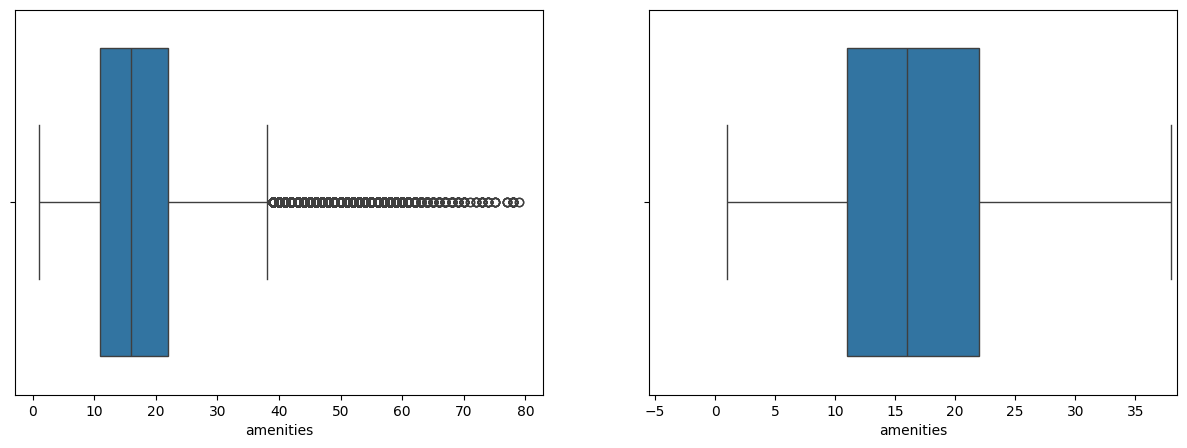

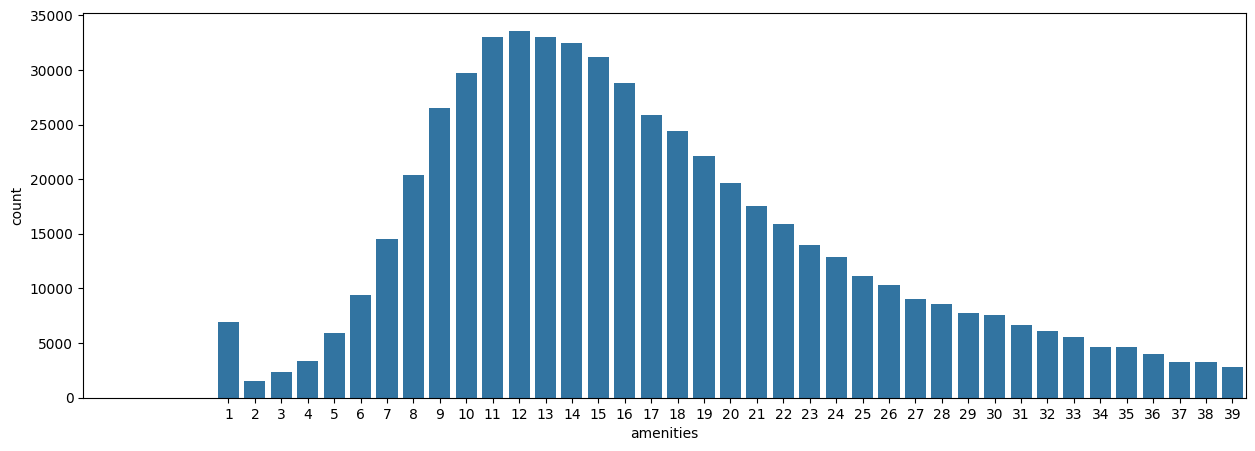

In [45]:
boxplot_builder(base_airbnb["amenities"])
barplot_builder(base_airbnb["amenities"])

In [46]:
base_airbnb, removed_lines = remove_outliers(base_airbnb, "amenities")
print("numero de linhas removidas: ", removed_lines)

numero de linhas removidas:  24343


#### Latitude e Longitude (Mapa das propriedades)

In [68]:
amount = base_airbnb.sample(frac=0.05)
map_center = {"lat": amount.latitude.mean(), "lon": amount.longitude.mean()}

map_graph = px.density_map(
    data_frame=amount,
    lat="latitude",
    lon="longitude",
    z="price",
    radius=2.5,
    center=map_center,
    zoom=10,
    map_style="carto-voyager",
)
map_graph.show()